**2021/22**

# Stream Processing
This lecture is about processing a stream of data. 

We will rely on the structure streaming library of Apache Spark. 

## Structured streaming
A key aspect of structured streaming is to acquire/send data from a streaming data producer/consumer. That is, from a streaming source/sink.

Apache Spark provides methods to read/write from/to a stream, 
accordingly to some formats we may select from. Of course, some kind of configuration is required.

Firstly, there are the usual file-based formats like json, parquet, csv, text, parquet an so.
Also, we can use socket connections to get/send text data from/to TCP servers, and more importantly, we can rely on functionalities of advanced message systems like Apache Kafka, which will play a sort of buffering role. 

Secondly, we have to set an output mode, which defines how the results will be delivered. For instance, to see all data every time, only updates, or just the new records.

Further details can be found in https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html


# Problem formulation

This exercise builds upon the stock market prediction notebook we have worked upon in a previous lecture about classification. Recall that the main goal at the time was to create a ML binary classification model for the JaneStreetMarket dataset (https://www.kaggle.com/c/jane-street-market-prediction)

This time around we will use the ML model that has been created but now we will deal with a stream of trades that are expected to be processed, as if it was provided in real-time. Hence, we will simulate the real-time scenario.

The functional requirements for the Spark program we are going to create are as follows:
1. To load a ML model previously built.
2. To process trades on a daily basis, as it goes and according to the rules set for the score. That is, the daily score is computed as the sum of the product weight x resp (see data schema) of the trades the system opt to trade in that day. 

In [ ]:
# If we need to install some packages, e.g. matplotlib

# ! pip3 install matplotlib
# ! pip3 install seaborn

In [ ]:
# Some imports 

import os 
import time

import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


# Useful visualization functions

Some functions that we can use to plot data but as Python dataframes.

**Disclaimer**: these functions are broadly distributed among users. Further adjustments are needed and/or advisable. Feel free to use your own plotting functions.

In [ ]:
def plot(df, xcol, ycol):
    sns.lineplot(data=df, x=xcol, y=ycol)
    

In [ ]:
def plotScatter(df, xcol, ycol, huecol):
    sns.set_theme(style="white")
    sns.scatterplot(data=df, x=xcol, y=ycol, hue=huecol)
    

# Spark setup

In [ ]:
# Some Spark related imports we will use hereafter

import sys

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml import PipelineModel


In [ ]:
# Build a SparkSession instance if one does not exist. Notice that we can only have one per JVM

spark = SparkSession\
    .builder\
    .appName("Streaming")\
    .getOrCreate()


# Collect data 

In [ ]:
! pwd & ls -la


## Daily version of the dataset

We have to set up the data that is going to be classified on a daily basis. 

Notice that from the initial data set we are no longer interested on the training 
part of the data but only in the correspondent test data, created as result of the 
random data split process. 

We assume that the test data has been stored in a file as we are going to streaming and 
classify it.

**Important**: The code below should be moved into a new notebook as this task is supposed to be 
carried out once.

In [ ]:
# Read the data (test part of initial data set split)

df = spark.read.parquet("test-part-janestreetmarket")


In [ ]:
df.printSchema()
df.count()


In [ ]:
# checking number of trades in each day

df.groupBy("date").count().show()


In [ ]:
! ls -la test-janestreetmarket-by-date


In [ ]:
# the schema, should we need it later on

janestreetmarket_schema = df.schema
janestreetmarket_schema


## Simulated streaming version of daily data

In [ ]:
streaming = ( spark.readStream.schema(janestreetmarket_schema)
             .option("mode","DROPMALFORMED")
             .option("maxFilesPerTrigger", 1) # read one a file at a time
             .csv("test-janestreetmarket-by-date") # the directory containing data
            )


# Select the ML model

We are going to use of the model that was already been created and stored in file.

The model was trained using features as depicted in the matrix correlation below.

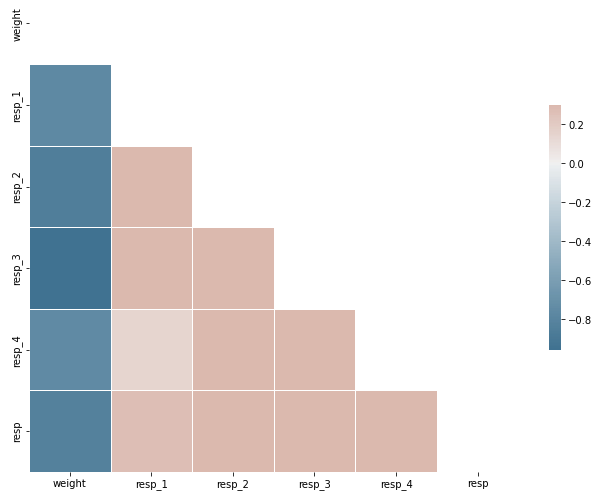

In [ ]:
# Load the ML model (not the simple pipeline)

model = PipelineModel.load("model-LinearSVM")


# Streaming data transformer

Let us set the operations to be applied to the stream.

In [ ]:
# Fit stream test data into the model

prediction = model.transform(streaming)


In [ ]:
# As in the notebook about binary classification, to compute the daily score 
# based on the trades made in that day, as weight * resp

daily_score = ( prediction
                   .withColumn("score", expr("weight * resp * prediction"))
                   .groupBy("date")
                   .agg(count("score").alias("trades"), sum("score").alias("total score"))
              )
    

In [ ]:
# Setting a query to deal with activity in the streaming data. 
# It will print updated aggregations to console

activity_query_1 = ( daily_score
                    .writeStream
                    .outputMode("complete")
                    .format("console")
                    .start()
                 )


In [ ]:
# In case we want to store the aggregates in an in-memory table (the sink). 
# The query name will be the table name

activity_query_2 = ( daily_score
                        .writeStream
                        .queryName("scoresTable")
                        .outputMode("complete")
                        .format("memory")
                        .start()
                   )


In [ ]:
# Some extra checks

spark.streams.active[0].isActive


In [ ]:
activity_query_1.status

# activity_query_2.status


In [ ]:
activity_query_1.lastProgress

# activity_query_2.lastProgress


# Exploring data

In [ ]:
# Figure out the tables we hold

spark.sql("show tables").show()


In [ ]:
# Interactively query in-memory table

spark.sql("select * from scoresTable").show()  


## Stopping the process

In [ ]:
# We can turn off the query now and eventually set up a different one

activity_query_1.stop()

# activity_query_2.stop()

In [ ]:
# Notice that in a production environment, we have to establish 
# that the query is awaiting termination so to prevent the driver 
# process from termination when when the stream is ative

# activity_query_1.awaitTermination()

# activity_query_2.awaitTermination()


# Additional exercise

Once this exercise is completed, create a new notebook with similar implementation but using a different streaming setup. Specifically, also relying on the messaging system Apache Kafka.


# References

* Learning Spark - Lightning-Fast Data Analytics, 2nd Ed. J. Damji, B. Wenig, T. Das, and D. Lee. O'Reilly, 2020
* Stream Processing with Apache Spark. G. Maas and F. Garillot. O'Reilly, 2019
* Spark: The Definitive Guide - Big Data Processing Made Simple, 1st Ed. B. Chambers and M. Zaharia. O'Reilly, 2018

